# divide observations into watermasses based on location

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
import cmocean as cm
import gsw

from cartopy import crs, feature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# for ellipse
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.stats import chi2, mode
from scipy.spatial.distance import mahalanobis

# for anova
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

In [3]:
grid = xr.open_dataset('/ocean/rbeutel/MOAD/analysis-becca/LiveOcean/grid.nc')
obs = pd.read_csv('./filtered_obs.csv')

In [4]:
set(obs.source)

{'GEOTRACES',
 'NCEI Coastal',
 'NCEI Coastal, NHL',
 'NCEI PNW',
 'NHL',
 'OCNMS',
 'ios bottle',
 'ios bottle, GEOTRACES',
 'ios bottle, NCEI PNW',
 'ios bottle, NCEI PNW, GEOTRACES',
 'ios ctd profiles',
 'ios ctd profiles, ios bottle',
 'ios mooring',
 'ios mooring, ios bottle',
 'ooi'}

In [5]:
# can't believe you haven't made a density column yet 
CT = gsw.CT_from_t(obs['salinity (g kg-1)'],obs['temperature (degC)'],obs['pressure (dbar)'])
rho = gsw.rho_alpha_beta(np.array(obs['salinity (g kg-1)']), CT, np.array(obs['pressure (dbar)']))[0]
obs['density (kg m-3)'] = rho

In [22]:
# can we be smarter about date division
# transition dates based on Bakun index analysis  
fall = pd.to_datetime(['1967-09-28T00:00:00.000000000', '1968-10-08T00:00:00.000000000',
       '1969-09-15T00:00:00.000000000', '1970-10-13T00:00:00.000000000',
       '1971-10-17T00:00:00.000000000', '1972-10-29T00:00:00.000000000',
       '1973-10-14T00:00:00.000000000', '1974-11-02T00:00:00.000000000',
       '1975-09-29T00:00:00.000000000', '1976-10-22T00:00:00.000000000',
       '1977-10-19T00:00:00.000000000', '1978-11-13T00:00:00.000000000',
       '1979-10-16T00:00:00.000000000', '1980-10-21T00:00:00.000000000',
       '1981-09-19T00:00:00.000000000', '1982-10-04T00:00:00.000000000',
       '1983-10-17T00:00:00.000000000', '1984-10-02T00:00:00.000000000',
       '1985-10-17T00:00:00.000000000', '1986-10-20T00:00:00.000000000',
       '1987-11-06T00:00:00.000000000', '1988-10-26T00:00:00.000000000',
       '1989-10-15T00:00:00.000000000', '1990-10-16T00:00:00.000000000',
       '1991-10-31T00:00:00.000000000', '1992-10-15T00:00:00.000000000',
       '1993-11-22T00:00:00.000000000', '1994-10-21T00:00:00.000000000',
       '1995-11-05T00:00:00.000000000', '1996-10-01T00:00:00.000000000',
       '1997-09-24T00:00:00.000000000', '1998-10-09T00:00:00.000000000',
       '1999-10-21T00:00:00.000000000', '2000-10-14T00:00:00.000000000',
       '2001-10-24T00:00:00.000000000', '2002-11-03T00:00:00.000000000',
       '2003-10-04T00:00:00.000000000', '2004-10-30T00:00:00.000000000',
       '2005-09-30T00:00:00.000000000', '2006-10-31T00:00:00.000000000',
       '2007-09-28T00:00:00.000000000', '2008-09-22T00:00:00.000000000',
       '2009-10-11T00:00:00.000000000', '2010-09-22T00:00:00.000000000',
       '2011-09-16T00:00:00.000000000', '2012-10-11T00:00:00.000000000',
       '2013-11-03T00:00:00.000000000', '2014-09-22T00:00:00.000000000',
       '2015-10-06T00:00:00.000000000', '2016-10-02T00:00:00.000000000',
       '2017-10-15T00:00:00.000000000', '2018-10-22T00:00:00.000000000',
       '2019-11-06T00:00:00.000000000', '2020-11-11T00:00:00.000000000',
       '2021-09-15T00:00:00.000000000', '2022-10-24T00:00:00.000000000',
       '2023-09-22T00:00:00.000000000'], utc=True)
spring =pd.to_datetime(['1967-03-27T00:00:00.000000000', '1968-03-26T00:00:00.000000000',
       '1969-04-26T00:00:00.000000000', '1970-03-15T00:00:00.000000000',
       '1971-04-13T00:00:00.000000000', '1972-03-21T00:00:00.000000000',
       '1973-03-19T00:00:00.000000000', '1974-04-08T00:00:00.000000000',
       '1975-03-21T00:00:00.000000000', '1976-04-09T00:00:00.000000000',
       '1977-03-11T00:00:00.000000000', '1978-03-07T00:00:00.000000000',
       '1979-03-14T00:00:00.000000000', '1980-03-01T00:00:00.000000000',
       '1981-03-24T00:00:00.000000000', '1982-03-03T00:00:00.000000000',
       '1983-04-01T00:00:00.000000000', '1984-04-18T00:00:00.000000000',
       '1985-02-14T00:00:00.000000000', '1986-03-26T00:00:00.000000000',
       '1987-03-12T00:00:00.000000000', '1988-04-05T00:00:00.000000000',
       '1989-04-04T00:00:00.000000000', '1990-03-25T00:00:00.000000000',
       '1991-04-08T00:00:00.000000000', '1992-03-04T00:00:00.000000000',
       '1993-04-26T00:00:00.000000000', '1994-03-23T00:00:00.000000000',
       '1995-03-22T00:00:00.000000000', '1996-04-25T00:00:00.000000000',
       '1997-03-30T00:00:00.000000000', '1998-02-21T00:00:00.000000000',
       '1999-03-29T00:00:00.000000000', '2000-03-18T00:00:00.000000000',
       '2001-02-21T00:00:00.000000000', '2002-03-22T00:00:00.000000000',
       '2003-04-11T00:00:00.000000000', '2004-03-29T00:00:00.000000000',
       '2005-05-22T00:00:00.000000000', '2006-04-18T00:00:00.000000000',
       '2007-03-11T00:00:00.000000000', '2008-03-27T00:00:00.000000000',
       '2009-03-03T00:00:00.000000000', '2010-04-04T00:00:00.000000000',
       '2011-03-29T00:00:00.000000000', '2012-04-19T00:00:00.000000000',
       '2013-03-19T00:00:00.000000000', '2014-03-20T00:00:00.000000000',
       '2015-02-12T00:00:00.000000000', '2016-03-23T00:00:00.000000000',
       '2017-04-22T00:00:00.000000000', '2018-02-01T00:00:00.000000000',
       '2019-04-06T00:00:00.000000000', '2020-01-31T00:00:00.000000000',
       '2021-03-19T00:00:00.000000000', '2022-04-20T00:00:00.000000000',
       '2023-04-22T00:00:00.000000000'], utc=True)

In [45]:
# first lets work with the data covered by the Bakun index
obs['season'] = 'none'
for i in range(len(spring)):
    obs.season[(obs.time-spring[i]>=dt.timedelta(days=0)) & (obs.time-fall[i]<dt.timedelta(days=0))] = 'up'
for i in range(len(spring)-1):
    obs.season[(obs.time-spring[i+1]<dt.timedelta(days=0)) & (obs.time-fall[i]>=dt.timedelta(days=0))] = 'down'


# then for the data before then choose a conservative split
obs.season[(obs.time-spring[0]<dt.timedelta(days=0)) & ((obs.month >=11) | (obs.month <=2))] = 'down'
obs.season[(obs.time-spring[0]<dt.timedelta(days=0)) & (obs.month >= 5) & (obs.month <=8)] = 'up'

In [50]:
# we're going to divide our watermasses differently during upwelling and downwelling
# so split into summer and winter datasets before we do this
# in the future i would like to split this data up based on the actual timing of upwelling and downwelling, but for now lets just do this simple separation 

# wob = obs[(obs.month >=11) | (obs.month <=2)]
# sob = obs[(obs.month >= 5) & (obs.month <=8)]
wob = obs[obs.season == 'down']
sob = obs[obs.season == 'up']

In [51]:
########################
# TS DIAGRAM FUNCTIONS #
########################

# I want to add lines of constant spice
smin, smax = 28.2,36.6
tmin, tmax = 1,19.6
bins = [np.linspace(smin, smax,100),np.linspace(tmin, tmax,100)]
SA, t = np.meshgrid(bins[0],bins[1])
p = np.array([50 for i in range(np.shape(SA)[0]*np.shape(SA)[1])])
p = p.reshape(100,100)

CT = np.zeros(np.shape(p))
rho = np.zeros(np.shape(p))
spice = np.zeros(np.shape(p))

for i in range(np.shape(p)[0]): 
    CT[i,:] = gsw.CT_from_t(SA[i,:],t[i,:],p[i,:])
    rho[i,:] = gsw.rho_alpha_beta(SA[i,:], CT[i,:], p[i,:])[0]
    spice[i,:] = gsw.spiciness0(SA[i,:], CT[i,:])

def fmt(x):
    x-=1000
    s = f"{x:.0f}"
    return rf"{s}"

def TS(df,region,ax, x, y):
    smin, smax = 28.2,36.6
    tmin, tmax = np.min(df[y]), np.max(df[y])

    salt = df[x][df.region == region].reset_index(drop=True)
    temp = df[y][df.region == region].reset_index(drop=True)

    bin = [np.linspace(smin,smax,100),np.linspace(tmin,tmax,100)]
    data, x_e, y_e = np.histogram2d(salt,temp, bins = bin, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ), data ,np.vstack([salt,temp]).T ,method = "splinef2d", bounds_error = False)
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]    
    ax.scatter(salt,temp, c=z, cmap=cm.cm.dense,s=1)

    title = region + "\n n= " + str(len(temp[~np.isnan(temp)]))
    ax.set_title(title)
    ax.set_ylabel(y)
    ax.set_xlabel(x)

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    if y == 'temperature (degC)' and x == 'salinity (g kg-1)':
        # density
        CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
        ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def TS_depth(df,region,ax):
    smin, smax = 28.2,36.6
    tmin, tmax = 1,19.6

    salt = df['salinity (g kg-1)'][df.region == region].reset_index(drop=True)
    temp = df['temperature (degC)'][df.region == region].reset_index(drop=True)
    z = df['depth (m)'][df.region == region].reset_index(drop=True)

    # Sort the points by depth, so that the deepest points are plotted last
    idx = z.argsort()
    salt, temp, z = salt[idx], temp[idx], z[idx]
                    
    sc = ax.scatter(salt,temp, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
    cb = fig.colorbar(sc, ax=ax)
    cb.set_label('Depth [m]', labelpad=10, fontsize=14)
    
    ax.set_title(region)
    ax.set_ylabel('Temperature')
    ax.set_xlabel('Salinity')

    ax.set_ylim([tmin,tmax])
    ax.set_xlim([smin,smax])

    # density
    CS=ax.contour(SA,t,rho,colors = 'gray', alpha=0.5)
    ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

def xy_depth(df,region,ax):

    ax.set_extent(xlim + ylim)
    ax.add_feature(feature.GSHHSFeature('auto', facecolor='whitesmoke', zorder=2))
    ax.add_feature(feature.GSHHSFeature('auto', edgecolor='k', zorder=4))

    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_K_200', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))
    ax.add_feature(feature.NaturalEarthFeature(name='bathymetry_J_1000', scale='10m', category='physical',facecolor='white', edgecolor='k',zorder=4))

    lon = df['longitude (degrees_east)'][(df.region == region)].reset_index(drop=True)
    lat = df['latitude (degrees_north)'][(df.region == region)].reset_index(drop=True)
    z = df['depth (m)'][(df.region == region)].reset_index(drop=True)
    idx = z.argsort()
    lon, lat, z = lon[idx], lat[idx], z[idx]

    ax.scatter(lon, lat, s=5,c=z,cmap=cm.cm.deep, transform=crs.PlateCarree(),zorder=7)
    ax.set_title(region)

In [52]:
############
# ELLIPSES #
############

def confidence_ellipse(x, y, ax, n_std=1, **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x_valid, y_valid)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor='none', **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(np.mean(x_valid), np.mean(y_valid))

    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)

def percentile_ellipse(x, y, ax, percentile=90, **kwargs):
    """
    Create a plot of an ellipse that covers a certain percentage of the data points,
    where the rotation and center are calculated based on the subset of data within the desired percentile.
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    # Stack x and y together for easier distance calculations
    data = np.column_stack([x_valid, y_valid])

    # Calculate the mean and covariance matrix of the full data
    mean = np.mean(data, axis=0)
    cov = np.cov(data, rowvar=False)
    inv_covmat = np.linalg.inv(cov)

    # Calculate the Mahalanobis distance for each point
    distances = np.array([mahalanobis(point, mean, inv_covmat) for point in data])

    # Get the distance cutoff for the given percentile
    cutoff_distance = np.percentile(distances, percentile)

    # Select the subset of points within the desired percentile
    subset_mask = distances <= cutoff_distance
    subset_data = data[subset_mask]

    # Calculate the mean and covariance for the subset of data
    subset_mean = np.mean(subset_data, axis=0)
    subset_cov = np.cov(subset_data, rowvar=False)

    # Eigenvalues and eigenvectors for scaling the ellipse
    eigvals, eigvecs = np.linalg.eigh(subset_cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The lengths of the ellipse axes
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(0.9, df=2))  # Adjust the scaling factor here

    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create the ellipse
    ellipse = Ellipse((subset_mean[0], subset_mean[1]),
                      width=width, height=height,
                      angle=angle, facecolor='none', **kwargs)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)
    return subset_mean[0], subset_mean[1], width, height, angle

def percentile_mode_ellipse(x, y, ax, percentile=90, **kwargs):
    """
    Create a plot of an ellipse that covers a certain percentage of the data points,
    where the rotation and center are calculated based on the subset of data within the desired percentile.
    this one is centered around the mode of the data instead of the mean
    """
    # Remove NaN values
    valid = ~np.isnan(x) & ~np.isnan(y)
    x_valid = x[valid]
    y_valid = y[valid]

    # Stack x and y together for easier distance calculations
    data = np.column_stack([x_valid, y_valid])

    # Calculate the mean and covariance matrix of the full data
    mean = np.mean(data, axis=0)
    dmode = mode(data, axis=0)[0]
    cov = np.cov(data, rowvar=False)
    inv_covmat = np.linalg.inv(cov)

    # Calculate the Mahalanobis distance for each point
    distances = np.array([mahalanobis(point, dmode, inv_covmat) for point in data])

    # Get the distance cutoff for the given percentile
    cutoff_distance = np.percentile(distances, percentile)

    # Select the subset of points within the desired percentile
    subset_mask = distances <= cutoff_distance
    subset_data = data[subset_mask]

    # Calculate the mean and covariance for the subset of data
    subset_mean = np.mean(subset_data, axis=0)
    subset_cov = np.cov(subset_data, rowvar=False)

    # Eigenvalues and eigenvectors for scaling the ellipse
    eigvals, eigvecs = np.linalg.eigh(subset_cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The lengths of the ellipse axes
    width, height = 2 * np.sqrt(eigvals * chi2.ppf(0.9, df=2))  # Adjust the scaling factor here

    # Angle of the ellipse in degrees
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))

    # Create the ellipse
    ellipse = Ellipse((subset_mean[0], subset_mean[1]),
                      width=width, height=height,
                      angle=angle, facecolor='none', **kwargs)

    # Add the ellipse to the plot
    ax.add_patch(ellipse)
    

In [53]:
######################
# BOX PLOT FUNCTIONS #
######################

def box(df,regions,property,ax,**kwargs):
    tracer = [df[property][df.region==region] for region in regions]

    # Filter data using np.isnan (boxplots can't really handle nans)
    t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

    bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
    ticks = ["{}: {}".format(regions[i],str(len(t_filter[i]))) for i in range(len(regions))]
    ax.set_xticklabels(ticks,rotation=30,ha='right')
    ax.set_ylabel(property)

    return bplot

In [54]:
# SUMMER DIVISIONS

# all water masses are important in the summer (according to Lagrangian analysis) which complicates separation a bit

# CUC = slope water south of 50.5 & salinity greater than or equal to 33.8 (need to do sensitivity analysis on this salinity choice)
# north shelf = shelf water north of 49, slope water north of 49 in the top 200 m 
# south shelf = shelf water south of 47.3, slope was south of 47.3 with salinity less than 33.8
# brackish = salinity less than or equal to 32
# offshore = offshore of 2000 m contour

sob['region'] = 'none'
sob.region[(sob.location == 'offshore') & (sob['depth (m)']>=120)] = 'offshore deep'
sob.region[(sob.location == 'offshore') & (sob['depth (m)']<120)] = 'offshore surface'
sob.region[(sob.location == 'shelf') & (sob['latitude (degrees_north)'] >= 49)] = 'north'
sob.region[(sob.location == 'shelf') & (sob['latitude (degrees_north)'] <= 47.3)] = 'south'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] >= 49) & (sob['depth (m)'] <= 200)] = 'north'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 47.3) & (sob['salinity (g kg-1)'] < 33.7)] = 'south'
sob.region[(sob.location == 'slope') & (sob['latitude (degrees_north)'] <= 50.5) & (sob['salinity (g kg-1)'] >= 33.7)] = 'cuc'
sob.region[sob['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #471 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

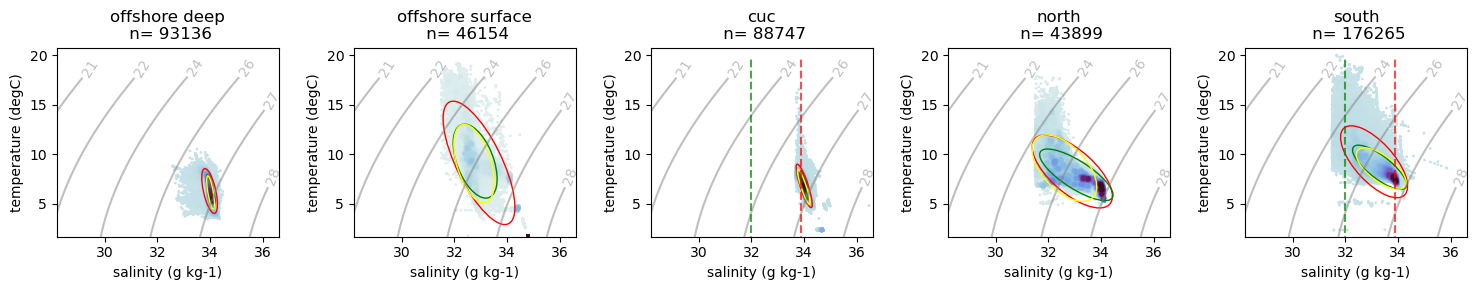

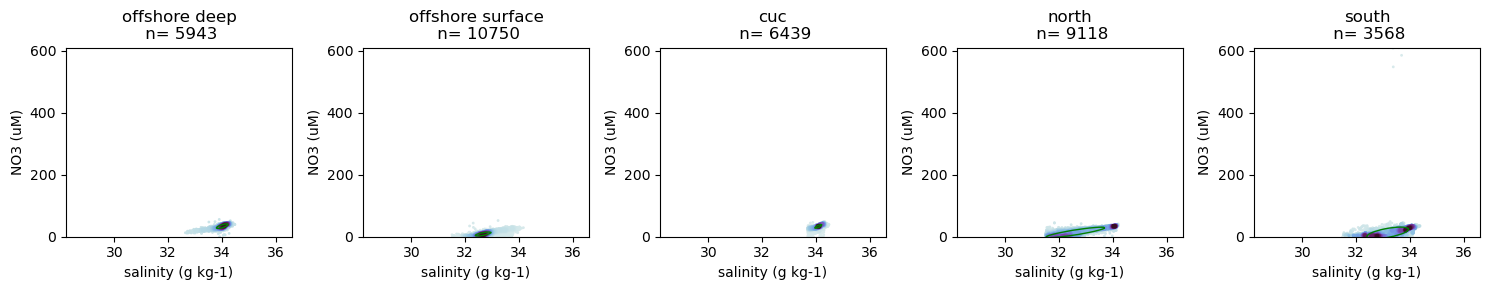

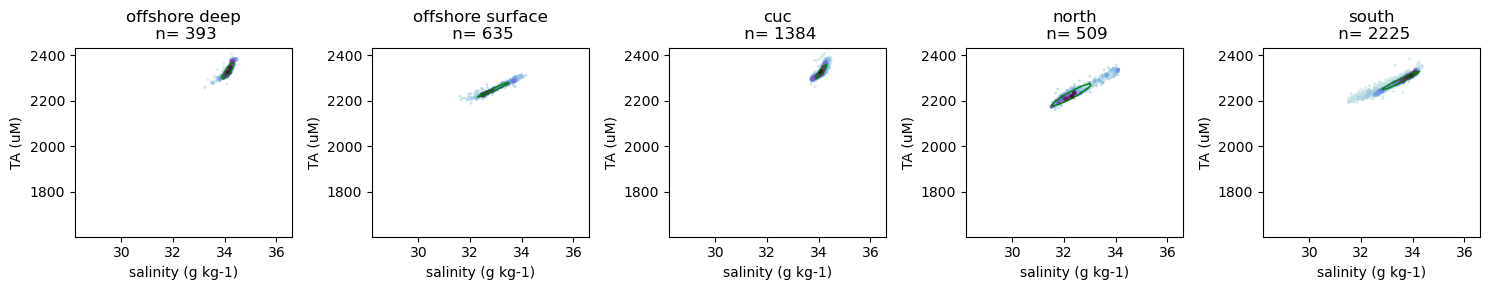

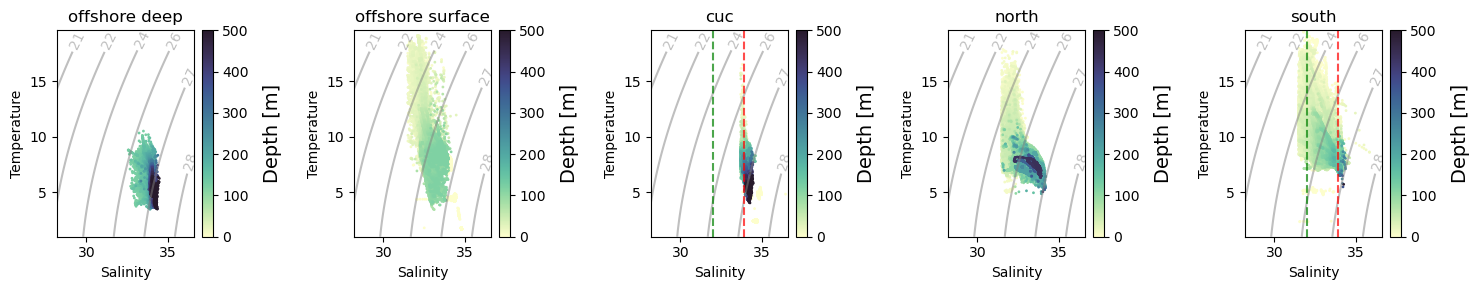

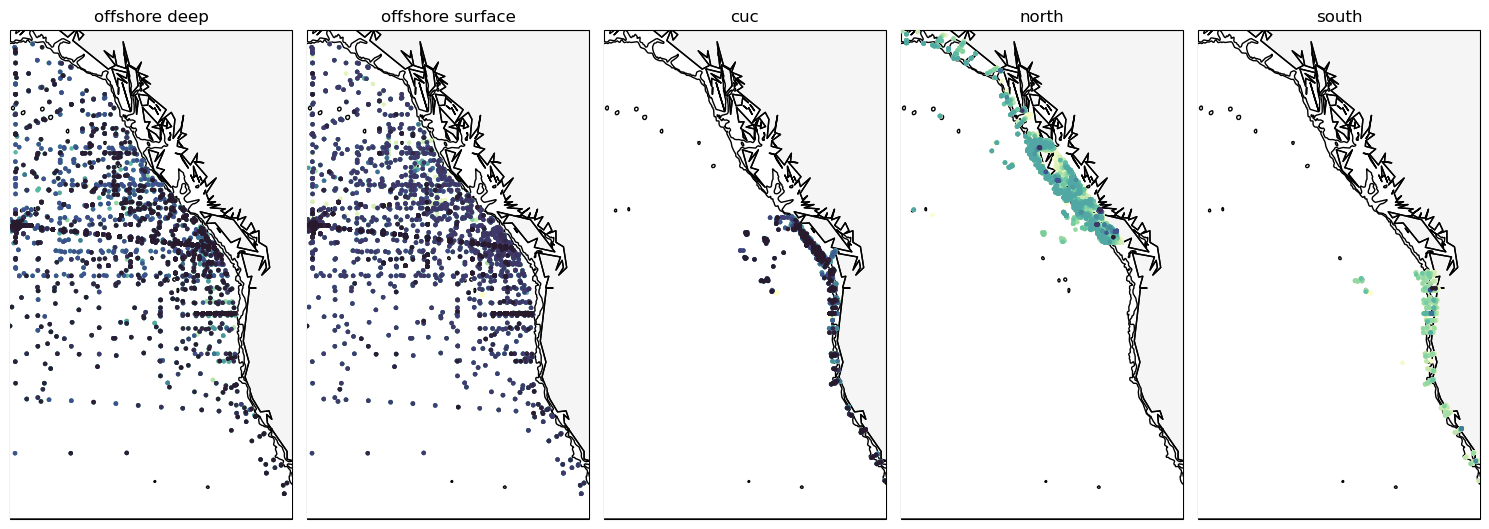

In [55]:
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

#elipse information
x_mean, y_mean, width, height, angle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','temperature (degC)')
    confidence_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], n_std=2, edgecolor='red')
    x_mean[i], y_mean[i], width[i], height[i], angle[i] = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], percentile=75, edgecolor='green')
    percentile_mode_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['temperature (degC)'][sob.region == regions[i]]), ax[i], percentile=75, edgecolor='yellow')


# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

# Nitrate - Salinity
#elipse information
NSx_mean, NSy_mean, NSwidth, NSheight, NSangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','NO3 (uM)')
    NSx_mean[i], NSy_mean[i], NSwidth[i], NSheight[i], NSangle[i] = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['NO3 (uM)'][sob.region == regions[i]]), ax[i], percentile=50, edgecolor='green')
plt.tight_layout()

# TA - Salinity
#elipse information
TASx_mean, TASy_mean, TASwidth, TASheight, TASangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(sob,regions[i],ax[i],'salinity (g kg-1)','TA (uM)')
    TASx_mean[i], TASy_mean[i], TASwidth[i], TASheight[i], TASangle[i] = percentile_ellipse(np.array(sob['salinity (g kg-1)'][sob.region == regions[i]]), np.array(sob['TA (uM)'][sob.region == regions[i]]), ax[i], percentile=50, edgecolor='green')
plt.tight_layout()

# TS coloured by depth
fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS_depth(sob,regions[i],ax[i])

# show boundaries from CIOPS analysis
ax[2].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[2].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[4].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[4].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

xlim, ylim = [-145.5, -120.2], [30, 60]
fig, ax = plt.subplots(1,5, figsize=(len(regions)*3,6), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
for i in range(len(ax)):
    xy_depth(sob,regions[i],ax[i])
plt.tight_layout()

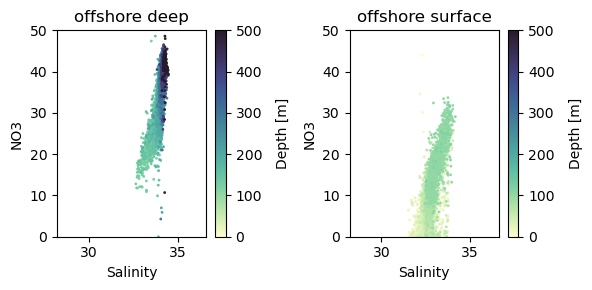

In [56]:
# ok i think its worth digging into those two groups that show up in the offshore plot of NO3-salinity

# no3-salinity space, coloured by depth
smin, smax = 28.2,36.6
nmin, nmax = 0,50
fig, ax = plt.subplots(1,2,figsize=[6,3])

r = ['offshore deep', 'offshore surface']
for i in range(len(r)):
    salt = sob['salinity (g kg-1)'][(sob.region == r[i])].reset_index(drop=True)
    no3 = sob['NO3 (uM)'][(sob.region == r[i])].reset_index(drop=True)
    z = sob['depth (m)'][(sob.region == r[i])].reset_index(drop=True)

    # Sort the points by depth, so that the deepest points are plotted last
    idx = z.argsort()
    salt, no3, z = salt[idx], no3[idx], z[idx]
                    
    sc = ax[i].scatter(salt,no3, c=z, cmap=cm.cm.deep,s=1,vmin=0,vmax=500)
    cb = fig.colorbar(sc, ax=ax[i])
    cb.set_label('Depth [m]', labelpad=10, fontsize=10)

    ax[i].set_title(r[i])
    
    ax[i].set_ylabel('NO3')
    ax[i].set_xlabel('Salinity')

    ax[i].set_ylim([nmin,nmax])
    ax[i].set_xlim([smin,smax])
plt.tight_layout()

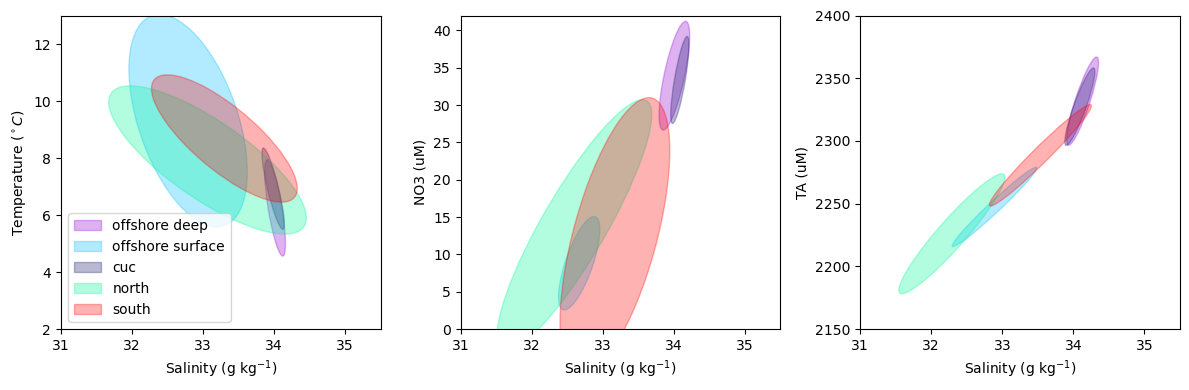

In [57]:
# lets plot all the ellipses together
colour = ['darkviolet','deepskyblue','midnightblue','mediumspringgreen','red']

fig, ax = plt.subplots(1,3,figsize=[12,4])

for i in range(len(regions)):
    # Create the ellipse
    ellipse = Ellipse((x_mean[i], y_mean[i]),
                      width=width[i], height=height[i],
                      angle=angle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3,
                      label=regions[i])

    # Add the ellipse to the plot
    ax[0].add_patch(ellipse)

    # Create the ellipse
    ellipse = Ellipse((NSx_mean[i], NSy_mean[i]),
                      width=NSwidth[i], height=NSheight[i],
                      angle=NSangle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3)

    # Add the ellipse to the plot
    ax[1].add_patch(ellipse)

    # Create the ellipse
    ellipse = Ellipse((TASx_mean[i], TASy_mean[i]),
                      width=TASwidth[i], height=TASheight[i],
                      angle=TASangle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3)

    # Add the ellipse to the plot
    ax[2].add_patch(ellipse)


ax[0].set_ylim([2,13])
ax[0].set_xlim([31,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')


ax[1].set_ylim([0,42])
ax[1].set_xlim([31,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')

ax[2].set_ylim([2150,2400])
ax[2].set_xlim([31,35.5])
ax[2].set_ylabel('TA (uM)')
ax[2].set_xlabel('Salinity (g kg$^{-1}$)')

ax[0].legend()
plt.tight_layout()

In [58]:
# # lets plot all the ellipses together
# colour = ['darkviolet','deepskyblue','midnightblue','mediumspringgreen','red']

# # LO ariane results
# LOxmean = [33.77666864, 33.89333029, 33.36770561, 33.04148093]
# LOymean = [6.5316104,  6.23492864, 7.29841359, 8.71926518]
# LOwidth = [2.45040867 ,1.5795744 , 2.78031865, 2.94314504]
# LOheight = [0.28385222 ,0.12860834, 0.47280694, 0.78123976]
# LOangle = [106.47423903 ,102.71199375 ,113.00224522 ,108.30265367]

# fig, ax = plt.subplots(1,1,figsize=[4,4])

# for i in range(len(regions)):
#     # Create the ellipse
#     ellipse = Ellipse((x_mean[i], y_mean[i]),
#                       width=width[i], height=height[i],
#                       angle=angle[i], facecolor=colour[i], 
#                       edgecolor=colour[i],alpha=0.3,
#                       label=regions[i])

#     # Add the ellipse to the plot
#     ax.add_patch(ellipse)

#     # Create the ellipse
#     ellipse = Ellipse((LOxmean[i], LOymean[i]),
#                       width=LOwidth[i], height=LOheight[i],
#                       angle=LOangle[i], facecolor='none', 
#                       edgecolor=colour[i],lw=2,ls='dashed',alpha=0.7)

#     # Add the ellipse to the plot
#     ax.add_patch(ellipse)

# ax.set_ylim([2,13])
# ax.set_xlim([31,35.5])
# ax.set_ylabel('Temperature ($^\circ C$)')
# ax.set_xlabel('Salinity (g kg$^{-1}$)')


# # these ellipses added outside of view for the sake of the legend
# # Create the ellipse
# ellipse = Ellipse((x_mean[i]+100, y_mean[i]+100),
#                       width=width[i], height=height[i],
#                       angle=angle[i], facecolor='k', 
#                       edgecolor='k',alpha=0.3,
#                       lw=2,label='Observations')

#     # Add the ellipse to the plot
# ax.add_patch(ellipse)
# ellipse = Ellipse((x_mean[i]+100, y_mean[i]+100),
#                       width=width[i], height=height[i],
#                       angle=angle[i], facecolor='none', 
#                       edgecolor='k',lw=2,ls='dashed', label='Model')
# # Add the ellipse to the plot
# ax.add_patch(ellipse)

# ax.legend()


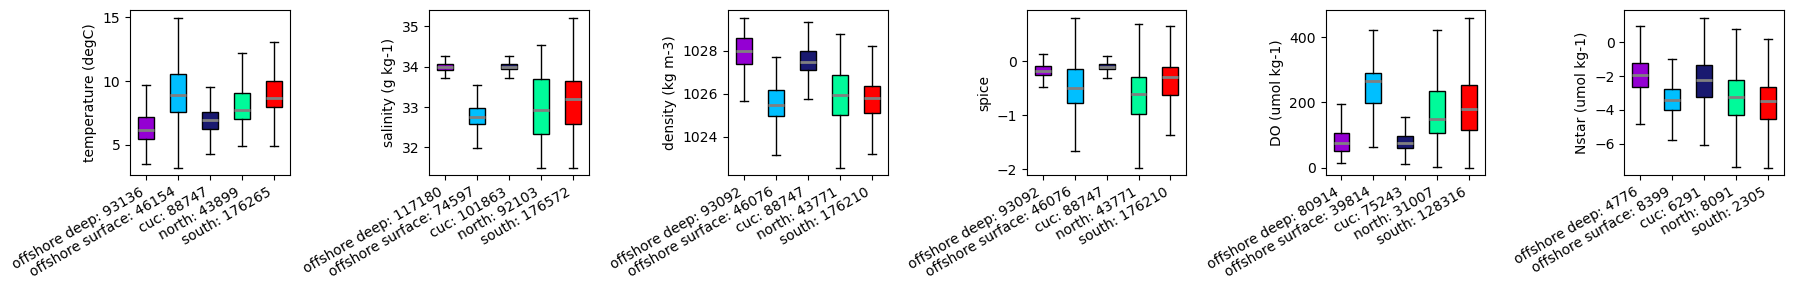

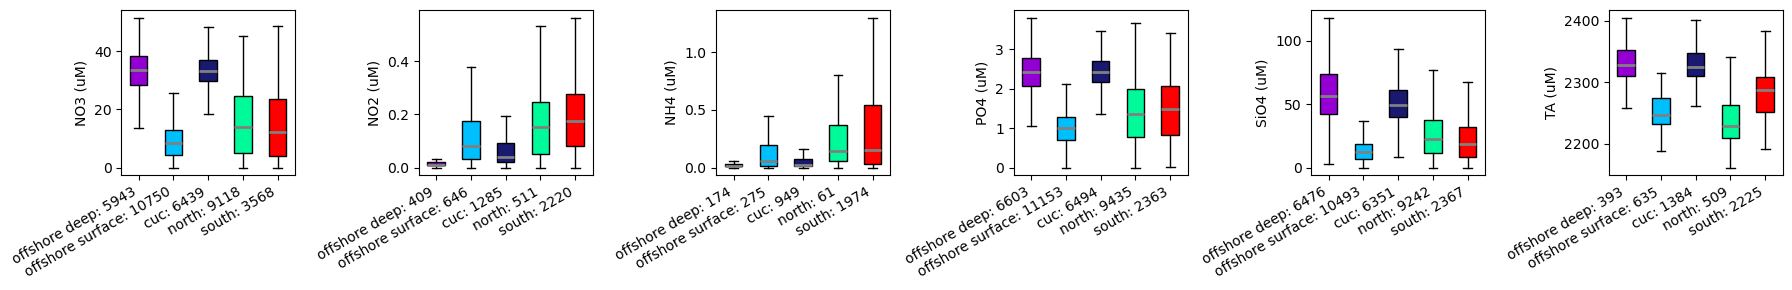

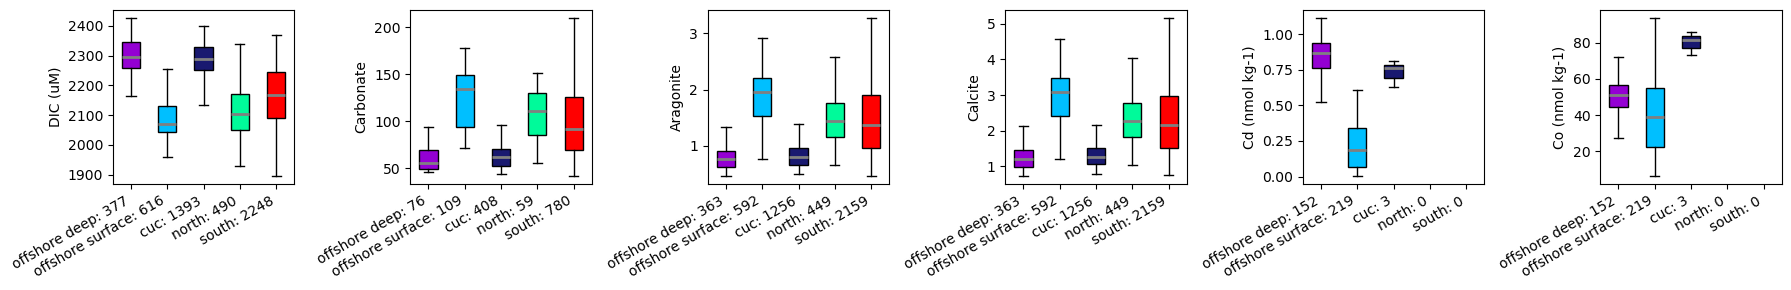

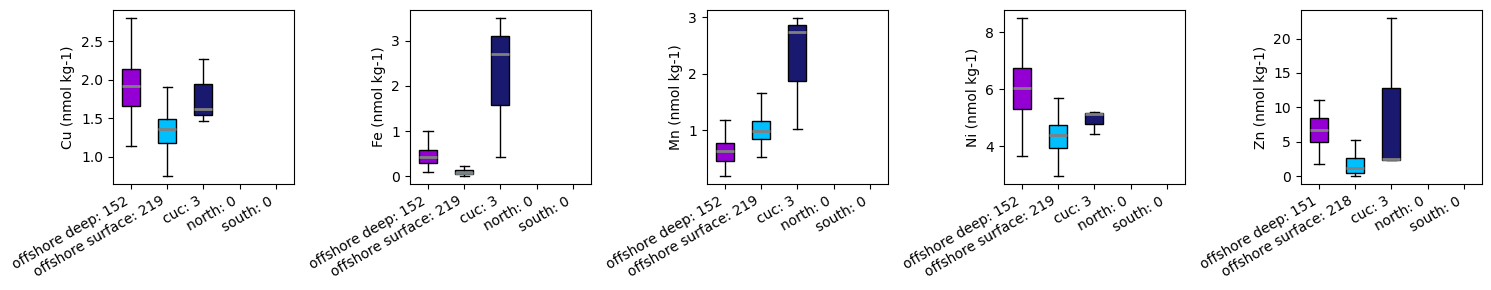

In [59]:
# box plots of different tracers
colour = ['darkviolet','deepskyblue','midnightblue','mediumspringgreen','red']

properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 'Nstar (umol kg-1)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
plt.tight_layout()

properties = ['NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
plt.tight_layout()

properties = ['DIC (uM)', 'Carbonate','Aragonite', 'Calcite','Cd (nmol kg-1)', 'Co (nmol kg-1)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
plt.tight_layout()


properties = [ 'Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(sob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
plt.tight_layout()
    

In [60]:
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
              'DIC (uM)', 'Carbonate','Aragonite', 'Calcite']

alpha = 0.01

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = sob.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')



temperature (degC)
Significant differences found between regions (p = 0.0000) at α = 0.01.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  p-adj   lower   upper  \
0               cuc             north    1.4466    0.0  1.4131  1.4802   
1               cuc     offshore deep   -0.5132    0.0 -0.5401 -0.4862   
2               cuc  offshore surface    2.3167    0.0  2.2837  2.3496   
3               cuc             south    2.4302    0.0  2.4066  2.4539   
4             north     offshore deep   -1.9598    0.0 -1.9931 -1.9266   
5             north  offshore surface    0.8700    0.0  0.8317  0.9083   
6             north             south    0.9836    0.0  0.9529  1.0142   
7     offshore deep  offshore surface    2.8298    0.0  2.7971  2.8625   
8     offshore deep             south    2.9434    0.0  2.9201  2.9666   
9  offshore surface             south    0.1136    0.0  0.0835  0.1436   

   reject  Cohen's d       OVL  
0    True

In [61]:
# other observations of tracer metals:

######################
# SALISH SEA or WCVI #
######################

# from Kuang et al. (2022) Factors controlling the temporal variability and spatial distribution of dissolved cadmium in the coastal Salish Sea
# at the JF2 mooring in JdF
cd_JF2_surface = 700/1000 # nmol/kg
cd_JF2_150m = 800/1000 # nmol/kg 

# from King et al. (2023) Polycyclic aromatic compound and trace metal element residues in Mytilus mussels at marine wildlife hotspots on the Pacific coast of Canada
# NOTE: results are from mussel soft tissue, not straight from water - but since these metals don't bioaccumulate much can we take them as a marker for water concentrations? - NOPE WAY TOO HIGH
# assuming mussels are mostly water, lets convert to nmol/kg 
# mandarte island in haro straight
cd_mand = (3.3 * (10**6))/112.41  # ug/g
cu_mand = (6.9 * (10**6))/63.546 # ug/g
ni_mand = (1.2 * (10**6))/58.69 # ug/g
zn_mand = (118 * (10**6))/65.38 # ug/g
# cleland island on the WCVI
cd_clel = (10.5 * (10**6))/112.41 # ug/g
cu_clel = (6.7 * (10**6))/63.546 # ug/g
ni_clel = (2.5 * (10**6))/58.69 # ug/g
zn_clel = (172 * (10**6))/65.38 # ug/g

##############
# NE PACIFIC #
##############

# from Bruland (1979) OCEANOGRAPHIC DISTRIBUTIONS OF CADMIUM, ZINC, NICKEL, AND COPPER IN THE NORTH PACIFIC
# offshore of san francisco profile site C-I March 1978, 37°0.0'N, 124°12.0'W
cd_CI_75 = 0.29 # nmol/kg
cd_CI_490 = 1.04 # nmol/kg
cu_CI_75 = 1.35 # nmol/kg
cu_CI_490 = 1.53 # nmol/kg
ni_CI_75 = 4.34 # nmol/kg
ni_CI_490 = 7.19 # nmol/kg
zn_CI_75 = 1.27 # nmol/kg
zn_CI_490 = 5.37 # nmol/kg

# from Landing & Bruland (1985) The contrasting biogeochemistry of iron and manganese in the Pacific Ocean
# same location as profiles from above source but from VERTEX cruise
mn_VI_0_250 = 1.73 # nmol/kg
mn_VI_0_750 = 1.34 # nmol/kg
fe_VI_0_250 = 1.31 # nmol/kg
fe_VI_0_750 = 1.96 # nmol/kg


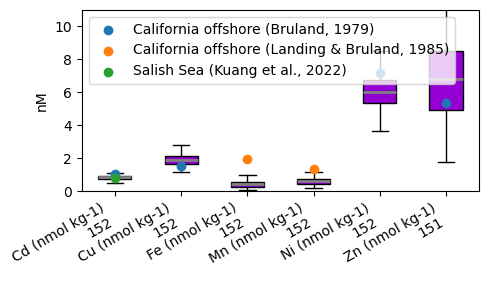

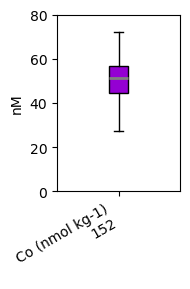

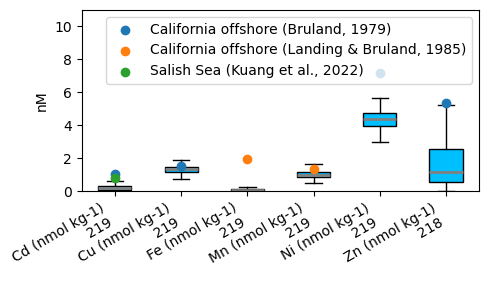

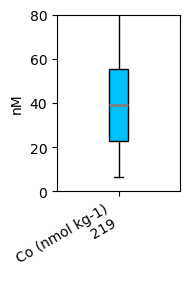

In [62]:
# box plot of just the offshore trace metals compared to what we get in the salish sea or what we expect in the pacific

properties = ['Cd (nmol kg-1)','Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)'] # put Co (nM ) on another axis
fig, ax = plt.subplots(1,1,figsize=[5,3])

tracer = [sob[prop][sob.region=='offshore deep'] for prop in properties]

# Filter data using np.isnan (boxplots can't really handle nans)
t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)


ticks = ["{}\n{}".format(properties[i],str(len(t_filter[i]))) for i in range(len(properties))]
ax.set_xticklabels(ticks,rotation=30,ha='right')
ax.set_ylabel('nM')
ax.set_ylim([0,11])

for patch in bplot['boxes']:
    patch.set_facecolor(colour[0])
for median in bplot['medians']:
    median.set_color('grey')
    median.set_linewidth(2)
plt.tight_layout()

# plot other measures of the trace metals
ax.scatter([1,2,5,6],[cd_CI_490,cu_CI_490,ni_CI_490,zn_CI_490],label='California offshore (Bruland, 1979)',zorder=5)
ax.scatter([3,4],[fe_VI_0_750,mn_VI_0_750],label='California offshore (Landing & Bruland, 1985)',zorder=5)
ax.scatter(1,cd_JF2_150m,label='Salish Sea (Kuang et al., 2022)',zorder=5)
ax.legend()

# colbalt separate bc soooo much higher
properties=['Co (nmol kg-1)']

fig, ax = plt.subplots(1,1,figsize=[2,3])

tracer = [sob[prop][sob.region=='offshore deep'] for prop in properties]

# Filter data using np.isnan (boxplots can't really handle nans)
t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
ticks = ["{}\n{}".format(properties[i],str(len(t_filter[i]))) for i in range(len(properties))]
ax.set_xticklabels(ticks,rotation=30,ha='right')
ax.set_ylabel('nM')
ax.set_ylim([0,80])

for patch in bplot['boxes']:
    patch.set_facecolor(colour[0])
for median in bplot['medians']:
    median.set_color('grey')
    median.set_linewidth(2)
plt.tight_layout()






# for surface
properties = ['Cd (nmol kg-1)','Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)'] # put Co (nM ) on another axis

fig, ax = plt.subplots(1,1,figsize=[5,3])

tracer = [sob[prop][sob.region=='offshore surface'] for prop in properties]

# Filter data using np.isnan (boxplots can't really handle nans)
t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)


ticks = ["{}\n{}".format(properties[i],str(len(t_filter[i]))) for i in range(len(properties))]
ax.set_xticklabels(ticks,rotation=30,ha='right')
ax.set_ylabel('nM')
ax.set_ylim([0,11])


for patch in bplot['boxes']:
    patch.set_facecolor(colour[1])
for median in bplot['medians']:
    median.set_color('grey')
    median.set_linewidth(2)
plt.tight_layout()

# plot other measures of the trace metals
ax.scatter([1,2,5,6],[cd_CI_490,cu_CI_490,ni_CI_490,zn_CI_490],label='California offshore (Bruland, 1979)',zorder=5)
ax.scatter([3,4],[fe_VI_0_750,mn_VI_0_750],label='California offshore (Landing & Bruland, 1985)',zorder=5)
ax.scatter(1,cd_JF2_150m,label='Salish Sea (Kuang et al., 2022)',zorder=5)
ax.legend()

# colbalt separate bc soooo much higher
properties=['Co (nmol kg-1)']

fig, ax = plt.subplots(1,1,figsize=[2,3])

tracer = [sob[prop][sob.region=='offshore surface'] for prop in properties]

# Filter data using np.isnan (boxplots can't really handle nans)
t_filter = [tracer[i][~np.isnan(tracer[i])] for i in range(len(tracer))]

bplot = ax.boxplot(t_filter, showfliers=False, patch_artist=True)
ticks = ["{}\n{}".format(properties[i],str(len(t_filter[i]))) for i in range(len(properties))]
ax.set_xticklabels(ticks,rotation=30,ha='right')
ax.set_ylabel('nM')
ax.set_ylim([0,80])


for patch in bplot['boxes']:
    patch.set_facecolor(colour[1])
for median in bplot['medians']:
    median.set_color('grey')
    median.set_linewidth(2)
plt.tight_layout()

In [63]:
# WINTER DIVISIONS

# really just south water important in the winter so i think the results will be less sensitive to N/S spatial divisions
# i'm also less worried about the JdF Eddy, so maybe its ok to take points near the entrance to the salish sea

# CUC = slope water south of 50.5 & salinity greater than or equal to 33.8 (need to do sensitivity analysis on this salinity choice)
# north shelf = shelf water north of 50.5, slope water north of 50.5 in the top 200 m
# south shelf = shelf water south of 50.5, slope water south of 50.5 with salinity less than 33.8
# brackish = salinity less than or equal to 32
# offshore = offshore of 2000 m contour

wob['region'] = 'none'
wob.region[(wob.location == 'offshore') & (wob['depth (m)']>=120)] = 'offshore deep'
wob.region[(wob.location == 'offshore') & (wob['depth (m)']<120)] = 'offshore surface'
wob.region[(wob.location == 'shelf') & (wob['latitude (degrees_north)'] >= 49)] = 'north'
wob.region[(wob.location == 'shelf') & (wob['latitude (degrees_north)'] <= 47.3)] = 'south'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] >= 49) & (wob['depth (m)'] <= 200)] = 'north'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 47.3) & (wob['salinity (g kg-1)'] < 33.7)] = 'south'
wob.region[(wob.location == 'slope') & (wob['latitude (degrees_north)'] <= 50.5) & (wob['salinity (g kg-1)'] >= 33.7)] = 'cuc'
wob.region[wob['salinity (g kg-1)'] <= 31.5] = 'brackish' # putting this one last will remove the <32 points from the other regions

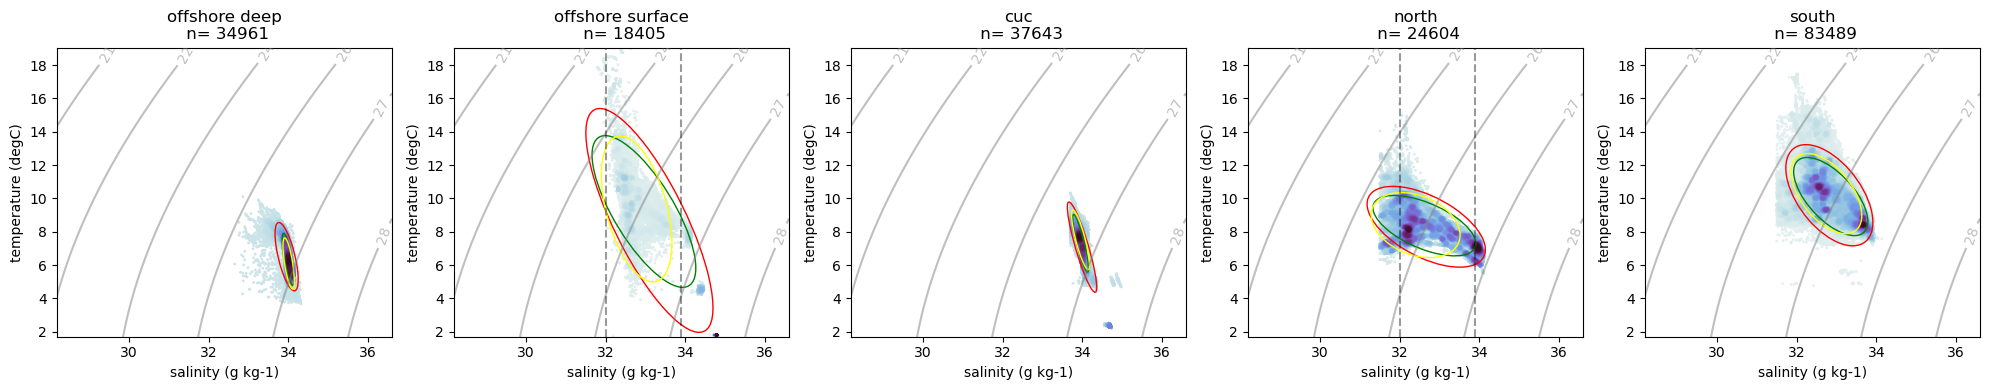

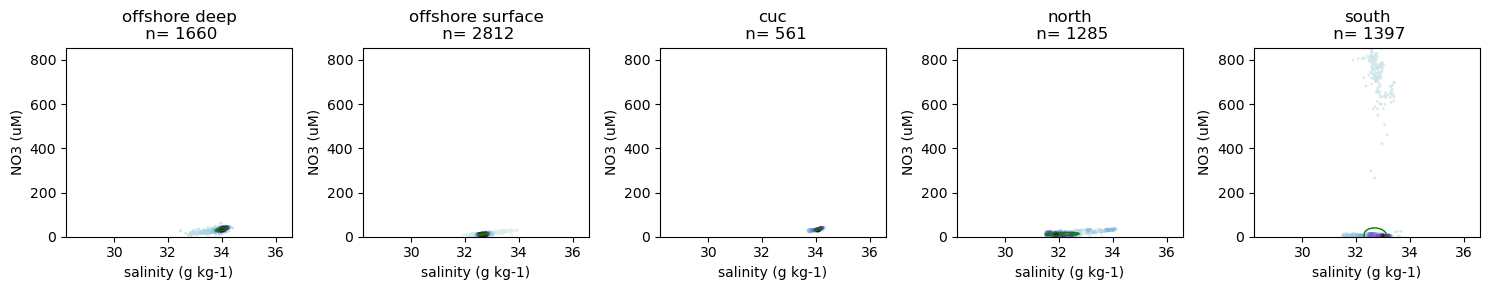

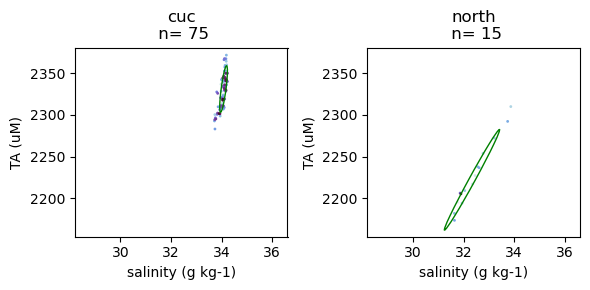

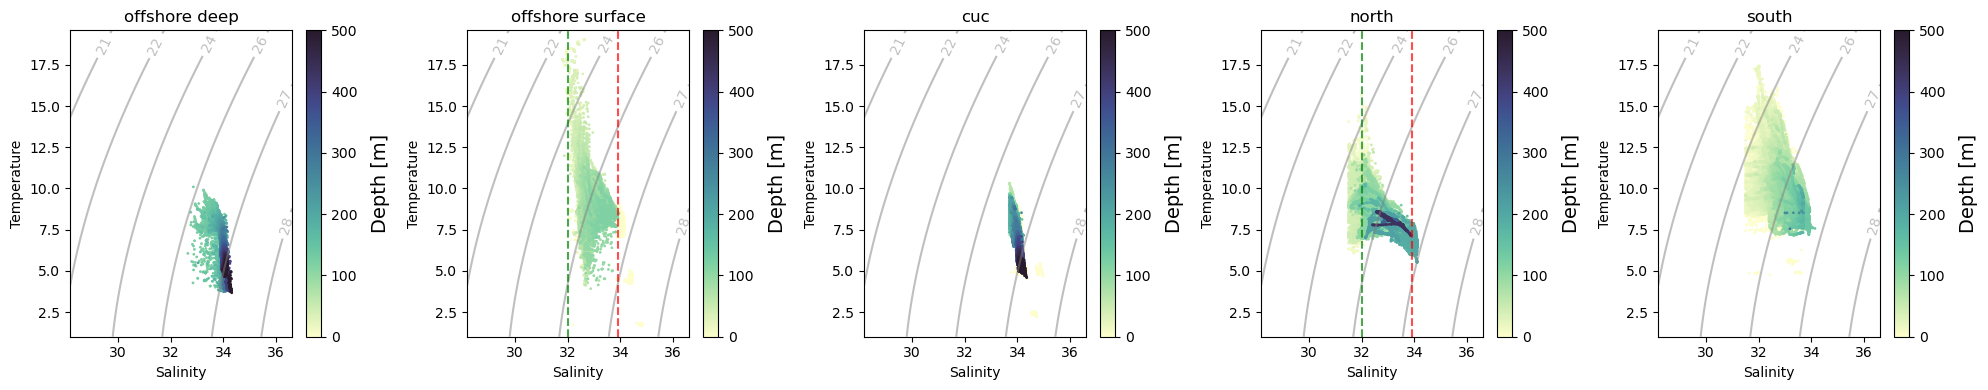

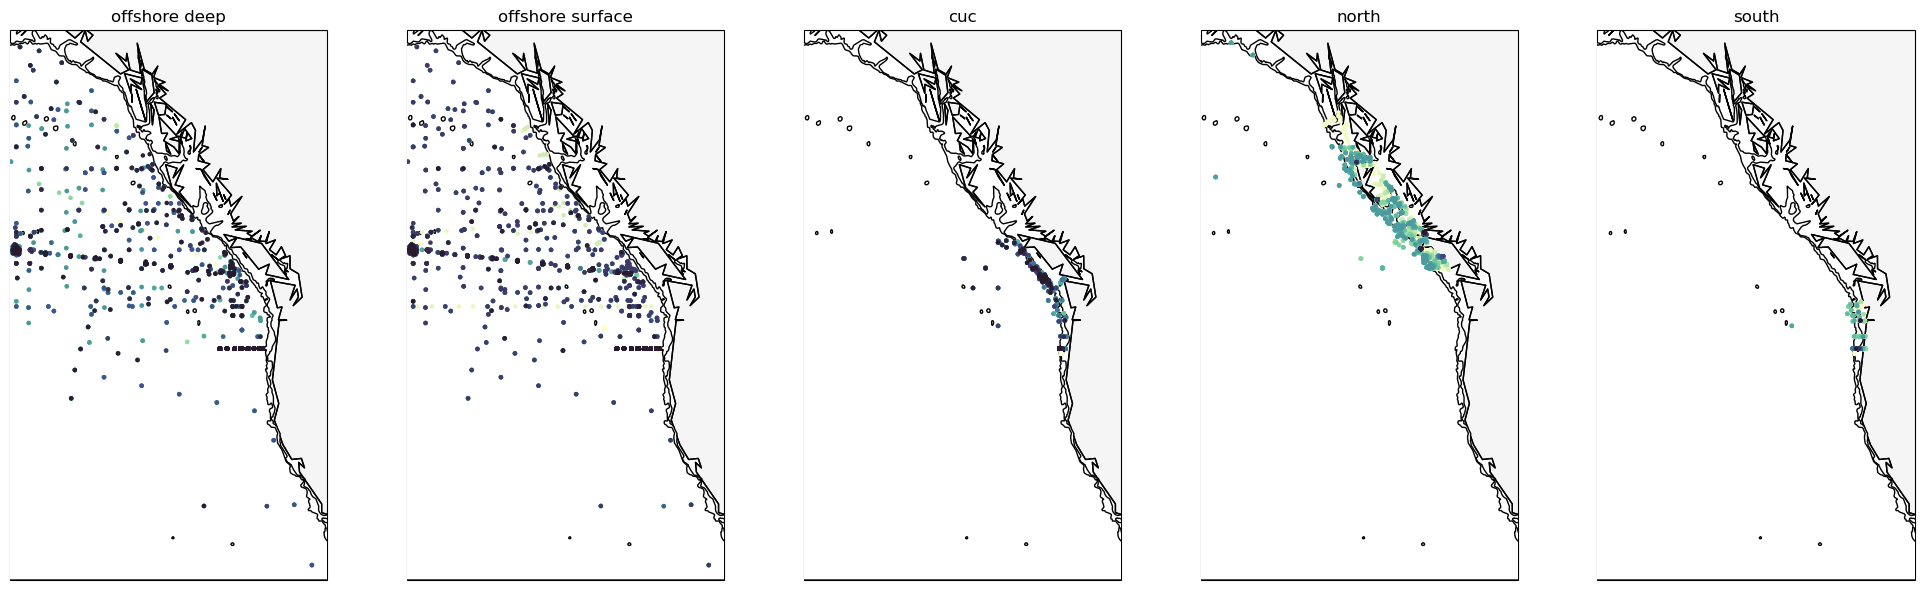

In [64]:
regions = ['offshore deep','offshore surface', 'cuc', 'north', 'south']

#elipse information
Wx_mean, Wy_mean, Wwidth, Wheight, Wangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*4,4])
for i in range(len(ax)):
    TS(wob,regions[i],ax[i],'salinity (g kg-1)','temperature (degC)')
    confidence_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], n_std=2, edgecolor='red')
    Wx_mean[i], Wy_mean[i], Wwidth[i], Wheight[i], Wangle[i] = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], percentile=75, edgecolor='green')
    percentile_mode_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['temperature (degC)'][wob.region == regions[i]]), ax[i], percentile=75, edgecolor='yellow')


# show boundaries from CIOPS analysis
ax[1].plot([33.9,33.9],[tmin,tmax],'k--', alpha=0.4, label='Deep division')
ax[1].plot([32,32],[tmin,tmax],'k--',alpha=0.4,label='Columbia division')
ax[3].plot([33.9,33.9],[tmin,tmax],'k--', alpha=0.4, label='Deep division')
ax[3].plot([32,32],[tmin,tmax],'k--',alpha=0.4,label='Columbia division')

plt.tight_layout()


# Nitrate - Salinity
#elipse information
wNSx_mean, wNSy_mean, wNSwidth, wNSheight, wNSangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*3,3])
for i in range(len(ax)):
    TS(wob,regions[i],ax[i],'salinity (g kg-1)','NO3 (uM)')
    wNSx_mean[i], wNSy_mean[i], wNSwidth[i], wNSheight[i], wNSangle[i] = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == regions[i]]), np.array(wob['NO3 (uM)'][wob.region == regions[i]]), ax[i], percentile=50, edgecolor='green')
plt.tight_layout()

# TA - Salinity
#elipse information
wTASx_mean, wTASy_mean, wTASwidth, wTASheight, wTASangle = np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions)), np.zeros(len(regions))
sub_regions=['cuc','north']
fig, ax = plt.subplots(1,len(sub_regions),figsize=[len(sub_regions)*3,3])
for i in range(len(ax)):
    TS(wob,sub_regions[i],ax[i],'salinity (g kg-1)','TA (uM)')
    wTASx_mean[i], wTASy_mean[i], wTASwidth[i], wTASheight[i], wTASangle[i] = percentile_ellipse(np.array(wob['salinity (g kg-1)'][wob.region == sub_regions[i]]), np.array(wob['TA (uM)'][wob.region == sub_regions[i]]), ax[i], percentile=50, edgecolor='green')
plt.tight_layout()

fig, ax = plt.subplots(1,len(regions),figsize=[len(regions)*4,4])
for i in range(len(ax)):
    TS_depth(wob,regions[i],ax[i])
# show boundaries from CIOPS analysis
ax[1].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[1].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
ax[3].plot([33.9,33.9],[tmin,tmax],'r--', alpha=0.7, label='Deep division')
ax[3].plot([32,32],[tmin,tmax],'g--',alpha=0.7,label='Columbia division')
plt.tight_layout()

xlim, ylim = [-145.5, -120.2], [30, 60]
fig, ax = plt.subplots(1,5, figsize=(len(regions)*4,6), subplot_kw={'projection': crs.Mercator(np.mean(xlim), *ylim)})
for i in range(len(ax)):
    xy_depth(wob,regions[i],ax[i])
plt.tight_layout()

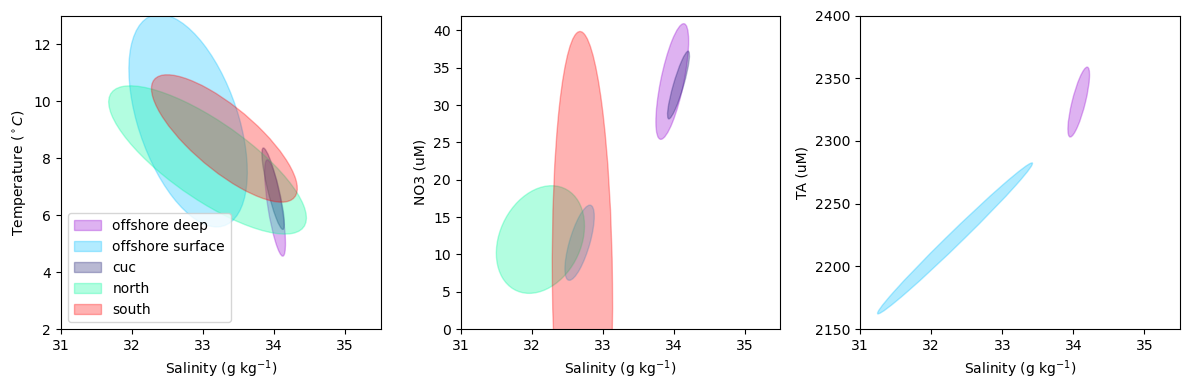

In [65]:
# lets plot all the ellipses together

fig, ax = plt.subplots(1,3,figsize=[12,4])

for i in range(len(regions)):
    # Create the ellipse
    ellipse = Ellipse((x_mean[i], y_mean[i]),
                      width=width[i], height=height[i],
                      angle=angle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3,
                      label=regions[i])

    # Add the ellipse to the plot
    ax[0].add_patch(ellipse)

    # Create the ellipse
    ellipse = Ellipse((wNSx_mean[i], wNSy_mean[i]),
                      width=wNSwidth[i], height=wNSheight[i],
                      angle=wNSangle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3)

    # Add the ellipse to the plot
    ax[1].add_patch(ellipse)

    # Create the ellipse
    ellipse = Ellipse((wTASx_mean[i], wTASy_mean[i]),
                      width=wTASwidth[i], height=wTASheight[i],
                      angle=wTASangle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3)

    # Add the ellipse to the plot
    ax[2].add_patch(ellipse)


ax[0].set_ylim([2,13])
ax[0].set_xlim([31,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')


ax[1].set_ylim([0,42])
ax[1].set_xlim([31,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')

ax[2].set_ylim([2150,2400])
ax[2].set_xlim([31,35.5])
ax[2].set_ylabel('TA (uM)')
ax[2].set_xlabel('Salinity (g kg$^{-1}$)')

ax[0].legend()
plt.tight_layout()

In [66]:
# lets plot all the ellipses together

# # LO ariane results
# LOxmean = [33.47413938, 33.7584284,  32.94355931, 32.85874228]
# LOymean = [7.30605078, 6.92505309, 8.88523306, 9.66397407]
# LOwidth = [4.49170249, 2.17786067 ,6.0291546 , 3.97315797]
# LOheight = [0.51230721, 0.21507746 ,0.45909681 ,0.97210777]
# LOangle = [107.95369756, 101.38173202, 102.12228685 ,105.99137396]

# fig, ax = plt.subplots(1,1,figsize=[4,4])

# for i in range(len(regions)):
#     # Create the ellipse
#     ellipse = Ellipse((Wx_mean[i], Wy_mean[i]),
#                       width=Wwidth[i], height=Wheight[i],
#                       angle=Wangle[i], facecolor=colour[i], 
#                       edgecolor=colour[i],alpha=0.3,
#                       label=regions[i])

#     # Add the ellipse to the plot
#     ax.add_patch(ellipse)

#     # Create the ellipse
#     ellipse = Ellipse((LOxmean[i], LOymean[i]),
#                       width=LOwidth[i], height=LOheight[i],
#                       angle=LOangle[i], facecolor='none', 
#                       edgecolor=colour[i],lw=2,ls='dashed',alpha=0.7)

#     # Add the ellipse to the plot
#     ax.add_patch(ellipse)

# ax.set_ylim([2,13])
# ax.set_xlim([31,35.5])
# ax.set_ylabel('Temperature ($^\circ C$)')
# ax.set_xlabel('Salinity (g kg$^{-1}$)')


# # these ellipses added outside of view for the sake of the legend
# # Create the ellipse
# ellipse = Ellipse((x_mean[i]+100, y_mean[i]+100),
#                       width=width[i], height=height[i],
#                       angle=angle[i], facecolor='k', 
#                       edgecolor='k',alpha=0.3,
#                       lw=2,label='Observations')

#     # Add the ellipse to the plot
# ax.add_patch(ellipse)
# ellipse = Ellipse((x_mean[i]+100, y_mean[i]+100),
#                       width=width[i], height=height[i],
#                       angle=angle[i], facecolor='none', 
#                       edgecolor='k',lw=2,ls='dashed', label='Model')
# # Add the ellipse to the plot
# ax.add_patch(ellipse)

# ax.legend()

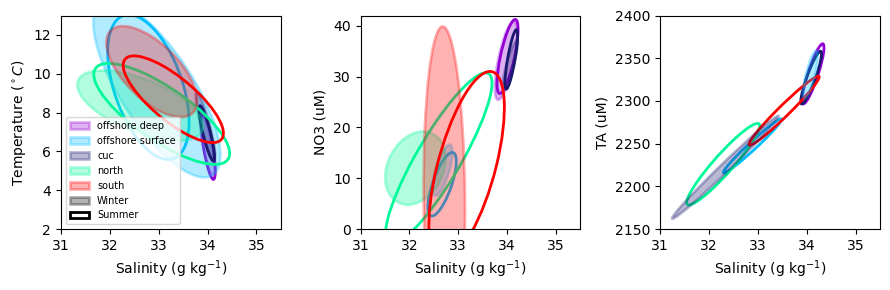

In [67]:
# compare summer and winter ellipses
# lets plot all the ellipses together

fig, ax = plt.subplots(1,3,figsize=[3*3,3])

for i in range(len(regions)):
    # Create the ellipse
    ellipse = Ellipse((Wx_mean[i], Wy_mean[i]),
                      width=Wwidth[i], height=Wheight[i],
                      angle=Wangle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3, lw=2,
                      label=regions[i])

    # Add the ellipse to the plot
    ax[0].add_patch(ellipse)
    ellipse = Ellipse((x_mean[i], y_mean[i]),
                      width=width[i], height=height[i],
                      angle=angle[i], facecolor='none', 
                      edgecolor=colour[i],lw=2)
    # Add the ellipse to the plot
    ax[0].add_patch(ellipse)

    ellipse = Ellipse((wNSx_mean[i], wNSy_mean[i]),
                      width=wNSwidth[i], height=wNSheight[i],
                      angle=wNSangle[i], facecolor=colour[i], 
                      edgecolor=colour[i],alpha=0.3, lw=2,
                      label=regions[i])

    # Add the ellipse to the plot
    ax[1].add_patch(ellipse)

    ellipse = Ellipse((NSx_mean[i], NSy_mean[i]),
                      width=NSwidth[i], height=NSheight[i],
                      angle=NSangle[i], facecolor='none', 
                      edgecolor=colour[i],lw=2)
    # Add the ellipse to the plot
    ax[1].add_patch(ellipse)

    ellipse = Ellipse((TASx_mean[i], TASy_mean[i]),
                      width=TASwidth[i], height=TASheight[i],
                      angle=TASangle[i], facecolor='none', 
                      edgecolor=colour[i],lw=2)
    # Add the ellipse to the plot
    ax[2].add_patch(ellipse)

for i in range(len(sub_regions)):
    ellipse = Ellipse((wTASx_mean[i], wTASy_mean[i]),
                      width=wTASwidth[i], height=wTASheight[i],
                      angle=wTASangle[i], facecolor=colour[i+1], 
                      edgecolor=colour[i+1],alpha=0.3, lw=2,
                      label=sub_regions[i])

    # Add the ellipse to the plot
    ax[2].add_patch(ellipse)


ax[0].set_ylim([2,13])
ax[0].set_xlim([31,35.5])
ax[0].set_ylabel('Temperature ($^\circ C$)')
ax[0].set_xlabel('Salinity (g kg$^{-1}$)')

ax[1].set_ylim([0,42])
ax[1].set_xlim([31,35.5])
ax[1].set_ylabel('NO3 (uM)')
ax[1].set_xlabel('Salinity (g kg$^{-1}$)')

ax[2].set_ylim([2150,2400])
ax[2].set_xlim([31,35.5])
ax[2].set_ylabel('TA (uM)')
ax[2].set_xlabel('Salinity (g kg$^{-1}$)')


# these ellipses added outside of view for the sake of the legend
# Create the ellipse
ellipse = Ellipse((Wx_mean[i]+100, Wy_mean[i]+100),
                      width=Wwidth[i], height=Wheight[i],
                      angle=Wangle[i], facecolor='k', 
                      edgecolor='k',alpha=0.3,
                      lw=2,label='Winter')

    # Add the ellipse to the plot
ax[0].add_patch(ellipse)
ellipse = Ellipse((x_mean[i]+100, y_mean[i]+100),
                      width=width[i], height=height[i],
                      angle=angle[i], facecolor='none', 
                      edgecolor='k',lw=2,label='Summer')
# Add the ellipse to the plot
ax[0].add_patch(ellipse)

ax[0].legend(fontsize=7)
plt.tight_layout()

#### NOTE: my summer and winter CUC definition overlaps well with ~40% PEW line (Newport - Vancouver Island Shelf) in figure 1 of Thomson and Krassovski (2010) for water between around 150-300 m deep

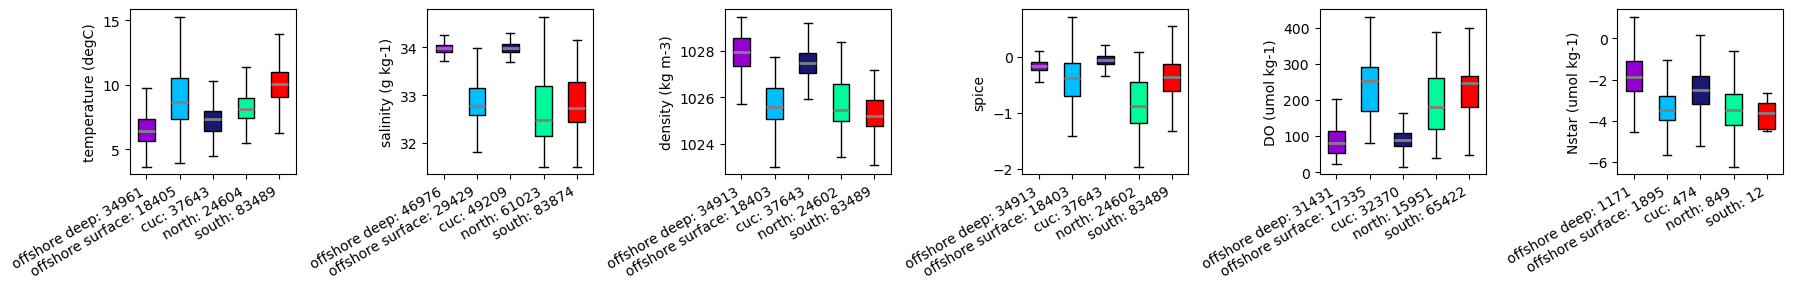

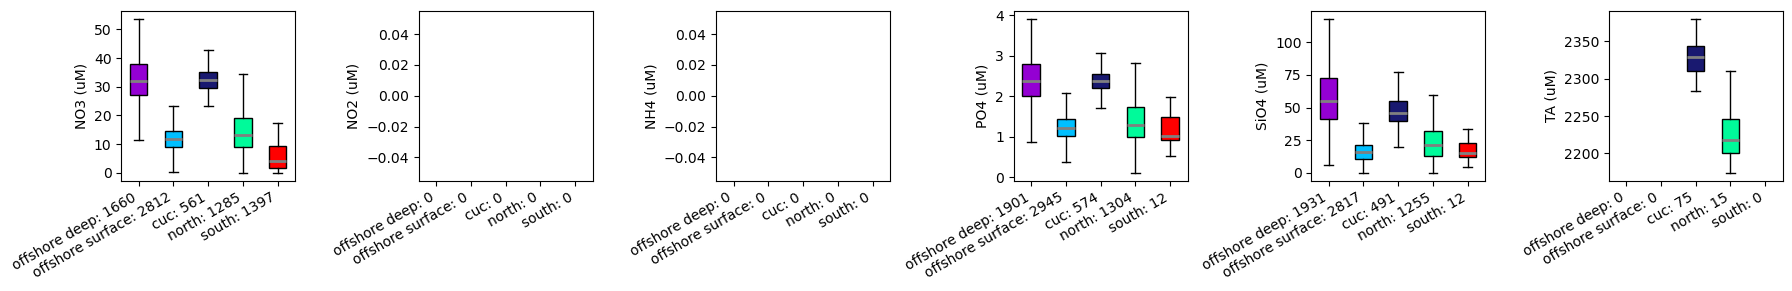

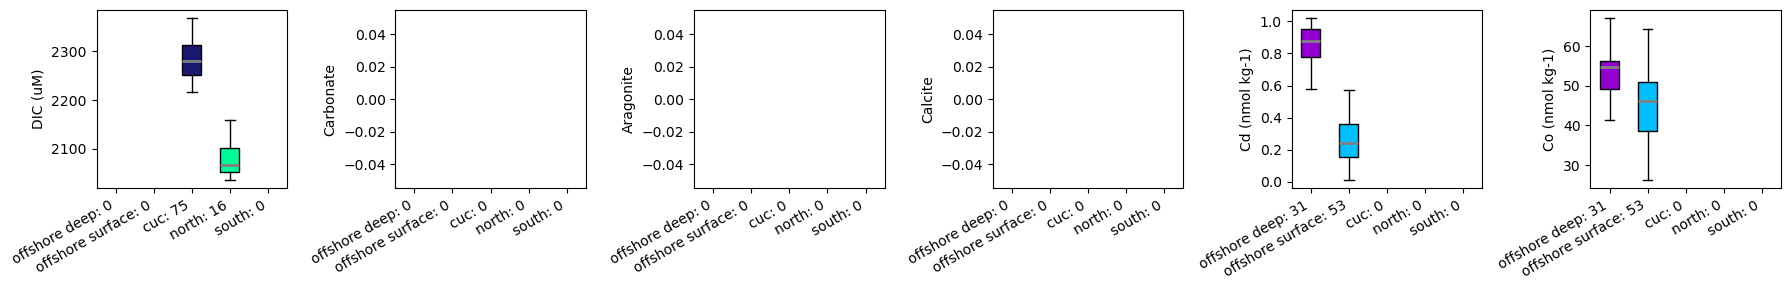

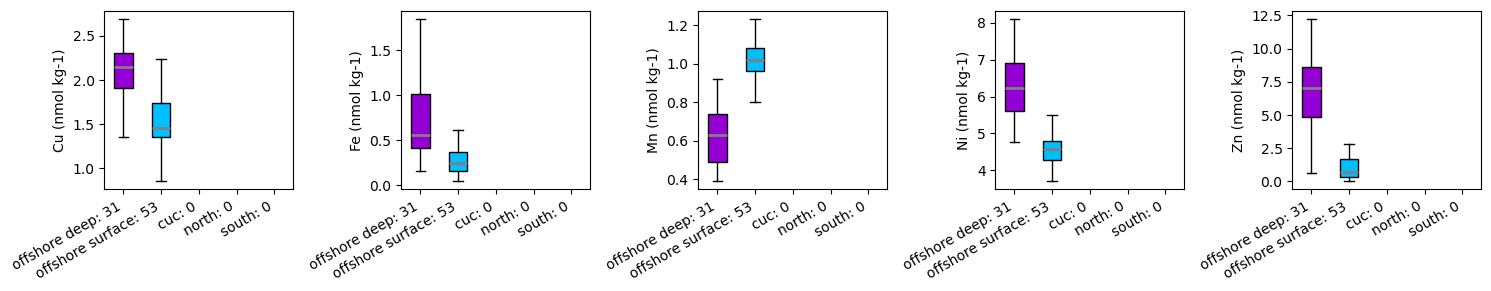

In [68]:
# box plots of different tracers

properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)','Nstar (umol kg-1)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
plt.tight_layout()

properties = ['NO3 (uM)','NO2 (uM)', 'NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
plt.tight_layout()

properties = [ 'DIC (uM)', 'Carbonate','Aragonite', 'Calcite','Cd (nmol kg-1)', 'Co (nmol kg-1)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
plt.tight_layout()

properties = [ 'Cu (nmol kg-1)','Fe (nmol kg-1)','Mn (nmol kg-1)','Ni (nmol kg-1)', 'Zn (nmol kg-1)']
fig, ax = plt.subplots(1,len(properties),figsize=[3*len(properties),3])
for i in range(len(properties)):
    bplot = box(wob,regions,properties[i],ax[i])
    for patch, color in zip(bplot['boxes'], colour):
        patch.set_facecolor(color)
    for median in bplot['medians']:
        median.set_color('grey')
        median.set_linewidth(2)
plt.tight_layout()

In [69]:
properties = ['temperature (degC)','salinity (g kg-1)','density (kg m-3)','spice','DO (umol kg-1)', 
              'Nstar (umol kg-1)','NO3 (uM)','NO2 (uM)','NH4 (uM)', 'PO4 (uM)', 'SiO4 (uM)', 'TA (uM)',
              'DIC (uM)', 'Carbonate','Aragonite', 'Calcite']

alpha = 0.01

for prop in properties:
    print(prop)
    # Filter out NaN values and exclude 'none' and 'brackish' regions
    obs_filtered = wob.dropna(subset=[prop])
    obs_filtered = obs_filtered[~obs_filtered['region'].isin(['none', 'brackish'])]

    # Perform one-way ANOVA
    groups = [obs_filtered[obs_filtered['region'] == region][prop] for region in ['cuc', 'offshore deep', 'offshore surface', 'south', 'north']]
    anova_result = stats.f_oneway(*groups)

    # Output ANOVA result
    if anova_result.pvalue < alpha:
        print(f"Significant differences found between regions (p = {anova_result.pvalue:.4f}) at α = {alpha}.\n")
        
        # Perform Tukey HSD test for post hoc analysis
        tukey_result = pairwise_tukeyhsd(endog=obs_filtered[prop], groups=obs_filtered['region'], alpha=alpha)
        
        # Extract Tukey results into a DataFrame
        tukey_df = pd.DataFrame(data=tukey_result._results_table.data[1:], columns=tukey_result._results_table.data[0])
        
        # Calculate Cohen's d and OVL for each pair of regions
        additional_results = []
        for i, row in tukey_df.iterrows():
            region1, region2 = row['group1'], row['group2']
            data1 = obs_filtered[obs_filtered['region'] == region1][prop]
            data2 = obs_filtered[obs_filtered['region'] == region2][prop]
            
            # Cohen's d calculation
            mean_diff = np.mean(data1) - np.mean(data2)
            pooled_std = np.sqrt((np.var(data1, ddof=1) + np.var(data2, ddof=1)) / 2)
            cohens_d = mean_diff / pooled_std if pooled_std != 0 else np.nan
            
            # Overlap Coefficient (OVL) calculation
            overlap_coef = 2 * stats.norm.cdf(-abs(cohens_d) / 2) if not np.isnan(cohens_d) else np.nan
            
            additional_results.append((cohens_d, overlap_coef))
        
        # Add Cohen's d and OVL to the DataFrame
        tukey_df[['Cohen\'s d', 'OVL']] = additional_results
        print("Tukey HSD post hoc results with Cohen's d and OVL:")
        print(tukey_df)
    else:
        print(f"No significant differences between regions (p = {anova_result.pvalue:.8f}) at α = {alpha}.")
    print('\n')



temperature (degC)
Significant differences found between regions (p = 0.0000) at α = 0.01.

Tukey HSD post hoc results with Cohen's d and OVL:
             group1            group2  meandiff  p-adj   lower   upper  \
0               cuc             north    1.2234    0.0  1.1794  1.2674   
1               cuc     offshore deep   -0.5689    0.0 -0.6088 -0.5290   
2               cuc  offshore surface    1.6040    0.0  1.5557  1.6523   
3               cuc             south    3.1161    0.0  3.0827  3.1494   
4             north     offshore deep   -1.7923    0.0 -1.8370 -1.7476   
5             north  offshore surface    0.3806    0.0  0.3282  0.4329   
6             north             south    1.8926    0.0  1.8537  1.9316   
7     offshore deep  offshore surface    2.1728    0.0  2.1240  2.2217   
8     offshore deep             south    3.6849    0.0  3.6507  3.7191   
9  offshore surface             south    1.5121    0.0  1.4684  1.5558   

   reject  Cohen's d       OVL  
0    True